# the model

Daniel Mayerhoffer, Eleonora Priori, Jan Schulz

Keeping the framework of an agent-based stock-flow consistent model rigorous, we aim at studying the effects of income perceptions on individuals' consumption choices

Comments welcome. Please do not quote.


Last updated: December 2022, 2022

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np
from tools import *
from metaActions import *
from generateSeeds import *
from plot import *
from initSeries import *
import sys

### Stock-flow ABM, with real and financial elements

- We observe both the real and monetary sides of the economy.

  

- We consider loans and deposits, with their interests.

  

- Enterprises have initial endowments.

  

- When agents abstein from consuming, their savings increase liquidity.

  

- Investments are uniquely for replacement, without technical progress.


- We consider agents' social network to observe their perceptions of income and inequality.


- We use this framework to study how the latter affect individuals' consumption choices.

  

- We use specific random sequences for both each agent and each function.

### symbol table

[symbol table](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) in $\LaTeX$

$a_i$ -  with $a_i \in \mathbf{A}$; agent number $N=|\mathbf{A}|$, `agentList` and`agentNum`

$a^e_i$ -  with $a^e_i \in \mathbf{A^e}$ and $\mathbf{A^e} \subset \mathbf{A}$; employer number $N^e=|\mathbf{A^e}|$ in range $[N^e_{min},N^e_{max}]$, `employerList`

$\mathbf{F}$ - firms' set, with $f_j \in \mathbf{F}$ being $N^f = |\mathbf{F}|$,  with $N^f = |\mathbf{F}| = |\mathbf{A^e}|$ , `firmList`

$\mathbf{A}^w$ - working agents' set, being $\mathbf{A}^w \subseteq \mathbf{A}$, with $N^w_{i,t}=|\mathbf{A}^w_i|$ number of working agents employed by employer $i$ at time $t$, also including self-employed employers, with $a_i \in \mathbf{A}^e$

$\mathbf{B}$ - banks' set, with $b_j \in \mathbf{B}$ being $N^b = |\mathbf{B}|$, `bankList`

$x^d$ - interest rate on deposits, `interestRateOnDeposits`

$x^{l^a}$ - interest rate on loans to (private) agents, `interestRateOnLoansVsAgents`

$x^{l^f}$ - interest rate on loans to firms, `interestRateOnLoansVsFirms`

$X^d_{a|f,b}$ - amount of positive interests on deposits for a given interval $t$ for agents ($a$) or firms ($f$), and negative for banks ($b$), `interestOnDeposits`

$X^l_{a|f,b}$ - amount of negative interests on loans for a given interval $t$ for agents ($a$) or firms ($f$), and positive for banks ($b$), `interestOnLoans`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~heterogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalHeterogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

$\Delta\pi_{i,t}$ - uniperiodal additive productivity correction in range $[\Delta\pi_{min},\Delta\pi_{max}]$, `productivityDelta`

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$\rho$ - profit distribution share, `rho`

$\delta_{i,t}$ - dividend $\rho\Pi_{i,t}$, `dividend` or `perceivedDividend` 

$W$ - wage `wage`

$R_{i,t}$ - revenues, `revenues`, including both sales revenues, `salesRevenues`, and active interests 

$s_{i,t}$ - sales in quantity, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

$I_{i,t}$  - investment plan  of $i$ in $t$, a uniformly distributed realization in range $[I_{min},I_{max}]$,`investmentProgram`

$\lambda$ -parameter limiting the investment plan, in $I_{i,t} \le \lambda\Pi_{i,t-1}$ , `Lambda`

$H_{i,t}$  - high powered money (cash) held by individuals (also acting as employers), `cashMoney`

$Q_{i,t}$ - checking account money deposits held by  $a_i$ at time $t$, eventually also negative `checkingAccount`

$Q^f_{i,t}$ - firm's bank account (with positive or negative balance), `bankAccount`

$Q^b_{i,t}$ - bank's account (with positive or negative balance) mantained with the central bank, `centralBankAccount`

$Q^T_{i,t}$ - bank treasury account at central bank, `bankTreasuryAccountAtCentralBank`

$\alpha$ - parameter determining the mean of the random normal distribution of the initial endowments of both firms and banks as $\alpha N^w_i$, being $i$ a firm or a bank, `alphaF` or `alphaB`

$\beta$ - parameter determining the standard deviation $\sigma$ of the random normal distribution of the initial endowments of both firms and banks, with $\sigma=\frac{\alpha}{\beta}N^w_i$, being $i$ a firm or a bank, `beta`

the investment and consumption actions are repeated in each cycle, looking around randomly for the sellers; currently `nOfConsumptionActions` $=30$ and `nOfInvestmentActions`$=10$; each consumption buy action is at maximum the 20% of the planned consumptions in that cycle; instead, each investment buy action can reach the whole amount of the investment program of the cycle; each buy action is limited by the residual capabilty of the seller

**magically**, the same good can be a consumption item or an investment one

$T$ - number of cycles `ncycles`

$t$ - current cycle `cycle`


## agent structure

The structure of an **agent**: it can represent an entrepreneur, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`
- its entrepreneur status, `entrepreneur`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- if entrepreneur, the id of its firm, `myFirm`, set to $0$
- $c_{i,0}$ - consumption rate, set to $0$
- $H_{i,0}$ - cash money, set to $0$ 
- $Q_{i,0}$ - checking account money deposits, set to $0$
- $NW_{i,0}$ - its social network, `myNetwork`

## firm structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, initial value  $0$
- $v^i_{i,0}$ - in**v**entories, `initialInventories`, set to $0$ 
- $v^f_{i,0}$ - in**v**entories, `finalInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $Q^f_{i,0}$ - firm's bank account, set to $0$
- $\pi_{i,t-1}$ set within the initialization step

## bank structure

- $R_{i,0}$ - `revenues`, initial value  $0$
- $I_{i,0}$  - investment plan, set to $0$
- $\Pi_{i,0}$ - profit, set to $0$, being the related dividend $D_{i,0}$, set to $0$
- $Q^b_{i,0}$ - bank's account mantained with the central bank, set to $0$
- $\pi_{i,t-1}$ set within the initialization step


# agents

each **agent** has the **function**:

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (W+D_{i,t-1}+X^d_{i,t-1}-X^l_{i,t-1})$; using $D_{i,t-1},X^d_{i,t-1},X^l_{i,t-1}$ we introduce lags with (possible) cyclical effect

  being $bu$ the buyer and $se$ the seller (firm), for each fraction $C_{i,t}/k$ 

  ($k$ is the number of buying actions in each cycle with random share [0,`maxConsumptionShareInSubstep`))

  $\Delta Q^f_{se,t}=C_{bu,t}/k$

  $\Delta Q_{bu,t}=-C_{bu,t}/k$


# firms

each **firm** has the **functions**:

- **produce** function (production in quantity), with:

  $\pi_{i,t}=\pi_{i,t-1}+\Delta\pi_{i,t}$

  $q_{i,t}=N^w_{i,t} \pi_{i,t}$

  

- **payWages**

  paying $W$ to each worker in each time $t$

  $\Delta Q_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  $\Delta Q^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$ 

  

- **buyInvestmentGoods**

  $I_{j,t}$ for $f_j \in \mathbf{F}$  ($I_{j,t}$ is exogenously set), , with $I_{i,t} \le \lambda\Pi_{i,t-1}$, being $\lambda\Pi_{i,t-1}$ a proxy of investment sustainability, introducing a lag with (possible) cyclical effect

  being $bu$ the buyer (firm) and $se$ the seller (firm), for each fraction $I_{j,t}/k$

  ($k$ is the number of investment actions in each cycle, with random share [0,`maxInvestmentShareInSubstep`))

  $\Delta Q^f_{se,t}=I_{bu,t}/k$

  $\Delta Q^f_{bu,t}=-I_{bu,t}/k$

  

- **makeBalanceSheet**

  $v^f_{i,t}=v^i_{i,t}+(q_{i,t}-s_{i,t}) (1 - d_{i})$

  $R_{i,t}=p s_{i,t}+X^d_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W N^w_{i,t}-X^l_{i,t}+p(v^f_{i,t}-v^i_{i,t})$

  reordering, we have:

  $\underbrace{\Pi_{i,t}+W N^w_{i,t}+X^l_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}+p(v^f_{i,t}-v^i_{i,t})}_{\textrm{indirect added value (*)}}$

  (*) the cost of bought-in materials and components is missing by construction in this version of the model

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​

  $\Delta Q_{i,t}=\delta_{i,t}$

  $\Delta Q^f_{i,t}=-\delta_{i,t}$


# banks

each **bank** has the **functions**:

- **produce** function (production of bank services in quantity), analogously with the firm one

  

- **payWages**

  paying $W$ to each worker in each time $t$

  $\Delta Q_{i,t}=W$ for  $a_i \in \mathbf{A}^w$ 

  $\Delta Q^f_{i,t}=-W \mathbf{N}^w_i$ for $a_i \in \mathbf{A}^e$

  

- **buyInvestmentGoods**

  $I_{j,t}$ for $f_j \in \mathbf{F}$  ($I_{j,t}$ is exogenously set), , with $I_{i,t} \le \lambda\Pi_{i,t-1}$, being $\lambda\Pi_{i,t-1}$ a proxy of investment sustainability, introducing a lag with (possible) cyclical effect

  being $bu$ the buyer (firm) and $se$ the seller (firm), for each fraction $I_{j,t}/k$

  ($k$ is the number of investment actions in each cycle, with random share [0,`maxInvestmentShareInSubstep`))

  $\Delta Q^f_{se,t}=I_{bu,t}/k$

  $\Delta Q^b_{bu,t}=-I_{bu,t}/k$

  

- **distributeDividend**

  $\delta_{i,t}=\rho\Pi_{i,t}$​​

  $\Delta Q_{i,t}=\delta_{i,t}$

  $\Delta Q^b_{i,t}=-\delta_{i,t}$

  

- **makeBalanceSheet**, with:

  being $d_{i}=1$ we have $v^f_{i,t}=v^i_{i,t}=0$

  $R_{i,t}=p s_{i,t}+\sum_{a_i}X^l_{i,t}+\sum_{f_i}X^l_{i,t}$

  $\Pi_{i,t}=R_{i,t}-W N^w_{i,t}-\sum_{a_i}X^d_{i,t}-\sum_{f_i}X^d_{i,t}$

  reordering, we have:

  $\underbrace{\Pi_{i,t}+W N^w_{i,t}+\sum_{a_i}X^d_{i,t}}_{\textrm{direct added value}}=\underbrace{R_{i,t}-\sum_{f_i}X^d_{i,t}}_{\textrm{indirect added value (*)}}$

  (*) the cost of bought-in materials and components is missing by construction in this version of the model, excepted the interests on deposits paid to firms		

  

- Every time we observe a transaction between an agent (or a firm) and its bank, we record the corresponding financial flow on the checking account (or bank account) of the agent (or firm) and on that mantained by the bank with the central bank 


- **debitingCheckingAccount** with $\mathcal{L}$ measuring the part which is a loan, if any

    For the amount $\mathcal{M} > 0$, debiting the account of agent $i$ at bank $j$

    $\Delta Q_i=-\mathcal{M}$

    With $\mathcal{L}=\begin{cases} 
0,&                        \text{if  } Q_{i,t-1} \geq 0 \land \mathcal{M} \leq Q_{i,t-1}\\
\mathcal{M}- Q_{i,t-1},&  \text{if  } Q_{i,t-1} \geq 0 \land \mathcal{M} \gt Q_{i,t-1}\\
\mathcal{M}, &             \text{if  } Q_{i,t-1} \lt 0
\end{cases}$

    modifying the correspondent bank $j$ deposit at the central bank

    $\Delta Q^b_j=-\mathcal{M} + \mathcal{L}$

    The account $Q_i$ can be positive or negative (in case, also accounted into the loans).


- **debitingBankAccount** with $\mathcal{L}$ measuring the part which is a loan, if any

    For the amount $\mathcal{M}$, debiting the account of firm $i$ at bank $j$

    $\Delta Q^f_i=-\mathcal{M}$

    With $\mathcal{L}=\begin{cases} 
0,&                          \text{if  } Q^f_{i,t-1} \geq 0 \land \mathcal{M} \leq Q^f_{i,t-1}\\
\mathcal{M}- Q^f_{i,t-1},&  \text{if  } Q^f_{i,t-1} \geq 0 \land \mathcal{M} \gt Q^f_{i,t-1}\\
\mathcal{M}, &               \text{if  } Q^f_{i,t-1} \lt 0
\end{cases}$

    modifying the correspondent bank $j$ deposit at the central bank

    $\Delta Q^b_j=-\mathcal{M} + \mathcal{L}$

    The account $Q^f_i$ can be positive or negative (in case, also accounted into the loans).
    

- **bankDebitingCentralBankAccount** 

    For the amount $\mathcal{M}$, debiting the account of bank $j$ at the central bank

    $\Delta Q^b_j=-\mathcal{M}$

    being the amount $\mathcal{M}$ a payment on charge of the bank, considering also the specific treasury account of bank $j$ 

    $\Delta Q^T_j=-\mathcal{M}$

    The account $Q^b_j$ can be positive or negative (in case, also accounted into the loans of the central bank).
    

- **creditingCheckingAccount** with $\mathcal{L}$ measuring the part which is a loan reinbursement, if any

    For the amount $\mathcal{M} > 0$, crediting the account of agent $i$ at bank $j$

    $\Delta Q_i=\mathcal{M}$

    With $\mathcal{L}=\begin{cases} 
\mathcal{M},&   \text{if  } Q_{i,t-1} \leq 0 \land \mathcal{M} \leq |Q_{i,t-1}|\\
|Q_{i,t-1}|,&  \text{if  } Q_{i,t-1} \leq 0 \land \mathcal{M} \gt |Q_{i,t-1}|\\
0, &            \text{if  } Q_{i,t-1} \gt 0
\end{cases}$

    modifying the correspondent bank $j$ deposit at the central bank

    $\Delta Q^b_j=\mathcal{M} - \mathcal{L}$

    The account $Q_i$ can be positive or negative (in case, also accounted into the loans).


- **creditingBankAccount** with $\mathcal{L}$ measuring the part which is a loan reinbursement, if any

    For the amount $\mathcal{M}$, crediting the account of firm $i$ at bank $j$

    $\Delta Q^f_i=-\mathcal{M}$

    With $\mathcal{L}=\begin{cases} 
\mathcal{M},&   \text{if  } Q^f_{i,t-1} \leq 0 \land \mathcal{M} \leq |Q^f_{i,t-1}|\\
|Q^f_{i,t-1}|,&  \text{if  } Q^f_{i,t-1} \leq 0 \land \mathcal{M} \gt |Q^f_{i,t-1}|\\
0, &            \text{if  } Q^f_{i,t-1} \gt 0
\end{cases}$

    modifying the correspondent bank $j$ deposit at the central bank

    $\Delta Q^b_j=\mathcal{M} - \mathcal{L}$

    The account $Q^f_i$ can be positive or negative (in case, also accounted into the loans).
    

- **bankCreditingCentralBankAccount** 

    For the amount $\mathcal{M}$, crediting the account of bank $j$ at the central bank

    $\Delta Q^b_j=\mathcal{M}$

    being the amount $\mathcal{M}$ a payment on charge of the bank, considering also the specific treasury account of bank $j$ 

    $\Delta Q^T_j=\mathcal{M}$

    The account $Q^b_j$ can be positive or negative (in case, also accounted into the loans of the central bank).
    

- **computeAndApplyInterests**



- interests on Loans to Firms (firm $i$ and bank $j$)

    we use $Q^f_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^l_{i,j}= Q^f_{i,t} x^{l^f}$
    
    $\Delta Q^f_{i,t}=-X^l_{i,j}$

    $\Delta Q^b_j = X^l_{i,j}$

    $\Delta Q^T_j = X^l_{i,j}$


- interests on Loans to Agents (agent $i$ and bank $j$)

    we use $Q^a_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^l_{i,j}= Q^a_{i,t} x^{l^a}$

    $\Delta Q^a_{i,t}=-X^l_{i,j}$

    $\Delta Q^b_j = X^l_{i,j}$

    $\Delta Q^T_j = X^l_{i,j}$


- interests on Deposits by Firms (firm $i$ and bank $j$)

    we use $Q^f_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^d_{i,j}= Q^f_{i,t} x^{d^f}$
 
    $\Delta Q^f_{i,t}=X^d_{i,j}$

    $\Delta Q^b_j = -X^d_{i,j}$

    $\Delta Q^T_j = -X^d_{i,j}$


- interests on Deposits by Agents (agent $i$ and bank $j$)

    we use $Q^a_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^d_{i,j}= Q^a_{i,t} x^{d^a}$
  
    $\Delta Q^a_{i,t}=X^d_{i,j}$

    $\Delta Q^b_j = -X^d_{i,j}$

    $\Delta Q^T_j = -X^d_{i,j}$

- **computeAndApplyInterests**



- interests on Loans to Firms (firm $i$ and bank $j$)

    we use $Q^f_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^l_{i,j}= Q^f_{i,t} x^{l^f}$
    
    $\Delta Q^f_{i,t}=-X^l_{i,j}$

    $\Delta Q^b_j = X^l_{i,j}$

    $\Delta Q^T_j = X^l_{i,j}$


- interests on Loans to Agents (agent $i$ and bank $j$)

    we use $Q^a_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^l_{i,j}= Q^a_{i,t} x^{l^a}$

    $\Delta Q^a_{i,t}=-X^l_{i,j}$

    $\Delta Q^b_j = X^l_{i,j}$

    $\Delta Q^T_j = X^l_{i,j}$


- interests on Deposits by Firms (firm $i$ and bank $j$)

    we use $Q^f_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^d_{i,j}= Q^f_{i,t} x^{d^f}$
 
    $\Delta Q^f_{i,t}=X^d_{i,j}$

    $\Delta Q^b_j = -X^d_{i,j}$

    $\Delta Q^T_j = -X^d_{i,j}$


- interests on Deposits by Agents (agent $i$ and bank $j$)

    we use $Q^a_{i,t}$, final balance of the interval, as if it had been constant throughout the period

    $X^d_{i,j}= Q^a_{i,t} x^{d^a}$
  
    $\Delta Q^a_{i,t}=X^d_{i,j}$

    $\Delta Q^b_j = -X^d_{i,j}$

    $\Delta Q^T_j = -X^d_{i,j}$



In [3]:
class Agent():
    def __init__(self, num,r,seed):
        self.num=num
        self.entrepreneur=False
        #self.myFirm=0
        self.myEnterprise=0
        self.myEmployer=0
        self.consumptionRate=0
        self.cashMoney=0
        self.checkingAccountTminus1=0
        self.checkingAccount=0
        self.perceivedWage=0
        self.perceivedDividend=0
        self.myBank=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.r=r.Random()
        self.r.seed(seed)
        self.myFirmBankList=[]
        
    def copyCheckingAccountBalance(self):
        self.checkingAccountTminus1=self.checkingAccount

    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=self.r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(self.perceivedWage+self.perceivedDividend+\
                self.interestOnDeposits-self.interestOnLoans)*self.consumptionRate
            if self.consumption < 0: self.consumption=0 

            self.interestOnDeposits=0
            self.interestOnLoans=0
            self.perceivedWage=0
            self.perceivedDividend=0
            self.madeConsumption=0
        
        if self.myFirmBankList==[]: self.myFirmBankList=cmv.firmList+cmv.bankList
        self.r.shuffle(self.myFirmBankList)
        mySeller=self.myFirmBankList[0]
        self.purchase=self.r.uniform(0,cmv.maxConsumptionShareInSubstep)*self.consumption 
                            # mean value should be calibrated with thenumber of buy action
        self.purchase=min(self.purchase,self.consumption-self.madeConsumption)
        self.purchase=min(self.purchase,cmv.price*(mySeller.production+\
                                        mySeller.initialInventories-mySeller.sales))
        if  self.purchase > 0:
            mySeller.sales+=self.purchase/cmv.price
            if mySeller.__class__.__name__=="Firm": mySeller.myBank.creditingBankAccount(mySeller,self.purchase)
            if mySeller.__class__.__name__=="Bank": \
                                        mySeller.bankCreditingCentralBankAccount(self.purchase) #mySeller is a bank
            self.myBank.debitingCheckingAccount(self,self.purchase)
            self.madeConsumption+=self.purchase
    


In [4]:
class Firm():
    def __init__(self, num, r,seed):
        self.num=num
        self.myWorkers=[]
        self.myEntrepreneur=0
        self.productivity=0
        self.initialInventories=0
        self.finalInventories=0
        self.bankAccount=0
        self.bankAccountTminus1=0
        self.salesRevenues=0 #sales*price
        self.revenues=0
        self.sales=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.investmentProgram=0
        self.profit=0
        self.madeInvestment=0
        self.interestOnDeposits=0
        self.interestOnLoans=0
        self.addedValue=0
        self.myBank=0
        self.r=r.Random()
        self.r.seed(seed)
        
    def copyBankAccountBalance(self):
        self.bankAccountTminus1=self.bankAccount
        
    def produce(self):
        # clean interests values while starting this cycle
        self.interestOnLoans=0
        self.interestOnDeposits=0
        
        self.initialInventories=self.finalInventories
        self.productivity+=self.r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.productivity=max(self.productivity,0)
        
        self.production=len(self.myWorkers)*self.productivity
        self.sales=0

    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.myBank.creditingCheckingAccount(anAgent,cmv.wage)
            #anAgent.checkingAccount+=cmv.wage
            #anAgent.myBank.centralBankAccount+=cmv.wage
        self.myBank.debitingBankAccount(self,cmv.wage*len(self.myWorkers))
        #self.bankAccount-=cmv.wage*len(self.myWorkers)
        #self.myBank.centralBankAccount-=cmv.wage*len(self.myWorkers)
            
    def buyInvestmentGoods(self,k):
        if k==0: 
            profitControl=max(0,self.profit)
            self.investmentProgram=\
                 min(r.uniform(cmv.investmentMin,cmv.investmentMax),cmv.Lambda*profitControl)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        if self.myInvestment > 0:
            mySeller.sales+=self.myInvestment/cmv.price
            mySeller.myBank.creditingBankAccount(mySeller,self.myInvestment)        
            self.myBank.debitingBankAccount(self,self.myInvestment)
            self.investmentProgram-=self.myInvestment
            self.madeInvestment+=self.myInvestment
        
    def makeBalanceSheet(self):
        self.lostProduction=0
        if self.production - self.sales > 0: 
            self.lostProduction=(self.production - self.sales)*self.deperibilityShare
        #print(self.num, lostProduction,self.productivity)
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-self.lostProduction
        self.salesRevenues=self.sales*cmv.price
        self.revenues=self.salesRevenues+self.interestOnDeposits
        self.profit=self.revenues - len(self.myWorkers)*cmv.wage\
          - self.interestOnLoans + \
          (self.finalInventories-self.initialInventories)*cmv.price
        self.addedValue=self.profit+self.interestOnLoans+len(self.myWorkers)*cmv.wage
        
    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.myEntrepreneur.perceivedDividend=dividend        
            self.myEntrepreneur.myBank.creditingCheckingAccount(self.myEntrepreneur,dividend)

            self.myBank.debitingBankAccount(self,dividend)


In [5]:
class Bank(Firm):
    def __init__(self, num, r,seed):
        super().__init__(num,r,seed)
        self.myPrivateClients=[]
        self.myCommercialClients=[]
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0
        self.centralBankAccountTminus1=0
        self.centralBankAccount=0
        self.bankTreasuryAccountAtCentralBankTminus1=0
        self.bankTreasuryAccountAtCentralBank=0
        
        # attribute deletions
        del self.bankAccount
        del self.bankAccountTminus1
        del self.myBank
        
        self.myPrivateClientsTotalInterestOnDeposits=0
        self.myPrivateClientsTotalInterestOnLoans=0
        self.myCommercialClientsTotalInterestOnDeposits=0
        self.myCommercialClientsTotalInterestOnLoans=0

        self.r=r.Random()
        self.r.seed(seed)

    def copyAccountsAtCentralBank(self):   
        self.centralBankAccountTminus1=self.centralBankAccount
        self.bankTreasuryAccountAtCentralBankTminus1=self.bankTreasuryAccountAtCentralBank
        
    def debitingCheckingAccount(self,aClient,amount): # agents' accounts
        if aClient.checkingAccount >= 0 and amount <= aClient.checkingAccount: L = 0
        if aClient.checkingAccount >= 0 and amount > aClient.checkingAccount: L = amount - aClient.checkingAccount
        if aClient.checkingAccount < 0: L = amount
        aClient.checkingAccount-=amount
        self.centralBankAccount+=-amount + L # look at central bank operation in debiting checking account formulas   

    def debitingBankAccount(self,aClient,amount): # firms' accounts
        if aClient.bankAccount >= 0 and amount <= aClient.bankAccount: L = 0
        if aClient.bankAccount >= 0 and amount > aClient.bankAccount: L = amount - aClient.bankAccount
        if aClient.bankAccount < 0: L = amount
        aClient.bankAccount-=amount
        self.centralBankAccount+=-amount + L # look at central bank operation in debiting bank account formulas

    def bankDebitingCentralBankAccount(self,amount):
        self.centralBankAccount-=amount
        self.bankTreasuryAccountAtCentralBank-=amount
        
    def creditingCheckingAccount(self,aClient,amount): # agents' accounts
        if aClient.checkingAccount <= 0 and amount <= abs(aClient.checkingAccount): L = amount
        if aClient.checkingAccount <= 0 and amount > abs(aClient.checkingAccount): L = abs(aClient.checkingAccount)
        if aClient.checkingAccount > 0: L = 0
        aClient.checkingAccount+=amount
        self.centralBankAccount+=amount - L # look at central bank operation in crediting checking account formulas
                
    def creditingBankAccount(self,aClient,amount): # firms' accounts
        if aClient.bankAccount <= 0 and amount <= abs(aClient.bankAccount): L = amount
        if aClient.bankAccount <= 0 and amount > abs(aClient.bankAccount): L = abs(aClient.bankAccount)
        if aClient.bankAccount > 0: L = 0
        aClient.bankAccount+=amount
        self.centralBankAccount+=amount - L # look at central bank operation in crediting bank account formulas

    def bankCreditingCentralBankAccount(self,amount):
        self.centralBankAccount+=amount
        self.bankTreasuryAccountAtCentralBank+=amount


    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.perceivedWage=cmv.wage
            anAgent.myBank.creditingCheckingAccount(anAgent,cmv.wage)
        self.bankDebitingCentralBankAccount(cmv.wage*len(self.myWorkers))

        
    def buyInvestmentGoods(self,k):
        if k==0: 
            profitControl=max(0,self.profit)
            self.investmentProgram=\
                 min(r.uniform(cmv.investmentMin,cmv.investmentMax),cmv.Lambda*profitControl)
            self.madeInvestment=0
                       
        self.r.shuffle(cmv.firmList)
        mySeller=cmv.firmList[0]
        self.myInvestment=self.r.uniform(0,cmv.maxInvestmentShareInSubstep)*self.investmentProgram
        self.myInvestment=min(self.myInvestment,cmv.price*(mySeller.production+\
                              mySeller.initialInventories-mySeller.sales))
        if self.myInvestment > 0:
            mySeller.sales+=self.myInvestment/cmv.price
            mySeller.myBank.creditingBankAccount(mySeller,self.myInvestment)        
            self.bankDebitingCentralBankAccount(self.myInvestment)
            self.investmentProgram-=self.myInvestment
            self.madeInvestment+=self.myInvestment

        
    def makeBalanceSheet(self):
        self.lostProduction=0
        #if self.production - self.sales > 0: 
        #    self.lostProduction=self.production - self.sales
        self.finalInventories=0
        self.salesRevenues=self.sales*cmv.price
        self.revenues=self.salesRevenues + self.myPrivateClientsTotalInterestOnLoans\
                                         + self.myCommercialClientsTotalInterestOnLoans

        self.profit=self.revenues - len(self.myWorkers)*cmv.wage\
           - self.myPrivateClientsTotalInterestOnDeposits - self.myCommercialClientsTotalInterestOnDeposits

        self.addedValue=self.profit+len(self.myWorkers)*cmv.wage\
          - self.myPrivateClientsTotalInterestOnLoans - self.myCommercialClientsTotalInterestOnLoans \
          + self.myPrivateClientsTotalInterestOnDeposits 
        

    def distributeDividend(self):
        if self.profit > 0:
            dividend=cmv.rho*self.profit
            self.myEntrepreneur.perceivedDividend=dividend        
            self.myEntrepreneur.myBank.creditingCheckingAccount(self.myEntrepreneur,dividend)

            self.bankDebitingCentralBankAccount(dividend)

            
    def computeAndApplyInterests(self):

        #interest are always calculate as positive values, then we add or subctract them 
        #to and from the accounts and we add them to revenues or costs
        
        for aPrivateClient in self.myPrivateClients:
            if aPrivateClient.checkingAccount >=0:                      #interests on Deposits by Agents 
                interests=aPrivateClient.checkingAccount*cmv.interestRateOnDeposits
                aPrivateClient.checkingAccount+=interests
                aPrivateClient.interestOnDeposits=interests
                self.bankCreditingCentralBankAccount(interests)
                
            else: #aPrivateClient.checkingAccount < 0                   #interests on Loans to Agents
                interests=abs(aPrivateClient.checkingAccount*cmv.interestRateOnLoansVsAgents)
                aPrivateClient.checkingAccount-=interests
                aPrivateClient.interestOnLoans=interests
                self.bankDebitingCentralBankAccount(interests)
               
        for aCommercialClient in self.myCommercialClients:
            if aCommercialClient.bankAccount >=0:                       #interests on Deposits by Firms 
                interests=aCommercialClient.bankAccount*cmv.interestRateOnDeposits
                aCommercialClient.bankAccount+=interests
                aCommercialClient.interestOnDeposits=interests
                self.bankDebitingCentralBankAccount(interests)

            else: #aCommercialClient.bankAccount < 0                    #interests on Loans to Firms 
                interests=abs(aCommercialClient.bankAccount*cmv.interestRateOnLoansVsFirms) 
                aCommercialClient.bankAccount-=interests
                aCommercialClient.interestOnLoans=interests
                self.bankCreditingCentralBankAccount(interests)
                
        self.myPrivateClientsTotalInterestOnDeposits=\
                 sum(list(self.myPrivateClients[i].interestOnDeposits for i \
                 in range(len(self.myPrivateClients))))
        
        self.myPrivateClientsTotalInterestOnLoans=\
                 sum(list(self.myPrivateClients[i].interestOnLoans    for i \
                 in range(len(self.myPrivateClients))))
        
        self.myCommercialClientsTotalInterestOnDeposits=\
                 sum(list(self.myCommercialClients[i].interestOnDeposits for i \
                 in range(len(self.myCommercialClients))))
        
        self.myCommercialClientsTotalInterestOnLoans=\
                 sum(list(self.myCommercialClients[i].interestOnLoans    for i \
                 in range(len(self.myCommercialClients))))
        
        
    def makeFinancialAccounts(self):
        self.myDebtsVsAgents=0
        self.myDebtsVsFirms=0
        self.myCreditsVsAgents=0
        self.myCreditsVsFirms=0

        for aPrivateClient in  self.myPrivateClients:
            if aPrivateClient.checkingAccount>=0: \
                self.myDebtsVsAgents+=aPrivateClient.checkingAccount
            if aPrivateClient.checkingAccount<0: \
                self.myCreditsVsAgents+=abs(aPrivateClient.checkingAccount)
        for aCommercialClient in  self.myCommercialClients:
            if aCommercialClient.bankAccount>=0: \
                self.myDebtsVsFirms+=aCommercialClient.bankAccount
            if aCommercialClient.bankAccount<0: \
                self.myCreditsVsFirms+=abs(aCommercialClient.bankAccount)
        
        

### agent setup

- agent basic creation

  

- creation of entrepreneur list

  

- selecting entrepreneurs and creating their firms or their banks

  

- with a given (heterogeneous) productivity

  

- linking the firm or the bank to its entrepreneur, considering the entrepreneur itself as a worker in its firm or bank

  

- creation of a temporary workforce list of to-be-employed agent, escluding entrepreneurs (already self employed)

  

- applying the unemployement rate to exclude agents

  

- assigning workforce (to-be-employed agents) to firms or banks, with a reinforcement mechanism, gradually giving more attraction/hiring capability to firms or banks growing the most

  

- assigning agents and firms to banks in a random way

  

- endowments provided to the enterprises are proportional to the initial workforce, being extracted from a random-normal distribution with $\mu=\alpha N^w_i$ and $\sigma=\frac{\alpha}{\beta}N^w_i$ (substituting $\alpha$ with $\alpha^f$ for the firms, or with $\alpha^b$ for the banks)

In [6]:
def setup(r,seed):
    
    seedManager(r,seed,'setup',setup)
    
    #print(r.random(),setup.r.random())
        
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1,r,cmv.agentSeedList[n])
        cmv.agentList.append(anAgent)
        
    # creation of: entrepreneur list; firm list; bank list
    cmv.entrepreneurNum=setup.r.randint(cmv.entrepreneurMin, cmv.entrepreneurMax)
    cmv.bankNum=setup.r.randint(cmv.bankMin, cmv.bankMax)
    
    cmv.entrepreneurList=[]
    cmv.firmList=[]
    cmv.bankList=[]
    entrepreneurCandidates=cmv.agentList.copy()

    for n in range(cmv.entrepreneurNum):
        
        i=setup.r.randint(0,len(entrepreneurCandidates)-1)
        
        entrepreneurCandidates[i].entrepreneur=True

        if len(cmv.bankList) < cmv.bankNum:
            newEnterprise=Bank(entrepreneurCandidates[i].num,\
                               r,cmv.bankSeedList[len(cmv.bankList)])
        else:
            newEnterprise=Firm(entrepreneurCandidates[i].num,\
                               r,cmv.firmSeedList[len(cmv.firmList)])

        entrepreneurCandidates[i].myEnterprise=newEnterprise
        entrepreneurCandidates[i].myEmployer=newEnterprise
        newEnterprise.myEntrepreneur=entrepreneurCandidates[i]
        newEnterprise.myWorkers.append(entrepreneurCandidates[i])
        newEnterprise.productivity=\
                setup.r.uniform(cmv.productivityMin,cmv.productivityMax)
        cmv.entrepreneurList.append(entrepreneurCandidates.pop(i))
        if newEnterprise.__class__.__name__=="Bank": cmv.bankList.append(newEnterprise)
        if newEnterprise.__class__.__name__=="Firm": cmv.firmList.append(newEnterprise)

    cmv.firmNum=len(cmv.firmList)
    
    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.entrepreneur: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(setup.r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)

    # assigning workforce to firms and banks
    tmpEnterpriseListWithDuplications=cmv.firmList+cmv.bankList
    for anAgent in toBeEmployed:
        choice=setup.r.choice(tmpEnterpriseListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalHeterogeneity: tmpEnterpriseListWithDuplications.append(choice)
            
            
    # assigning agents to firms and banks
    
    if len(cmv.bankList)>0:
        for anAgent in cmv.agentList:
            anAgent.myBank=setup.r.choice(cmv.bankList)
            anAgent.myBank.myPrivateClients.append(anAgent)
            
        for aFirm in cmv.firmList:
            aFirm.myBank=setup.r.choice(cmv.bankList)
            aFirm.myBank.myCommercialClients.append(aFirm)

    # assigning endowments to firms and banks

    cmv.totalInitFirmEndowments=0
    for aFirm in cmv.firmList:
        aFirm.initEn=setup.r.gauss(cmv.alphaF*len(aFirm.myWorkers),\
                     (cmv.alphaF/cmv.beta)*len(aFirm.myWorkers))
        aFirm.myBank.creditingBankAccount(aFirm,aFirm.initEn)
        cmv.totalInitFirmEndowments+=aFirm.initEn 


    cmv.totalInitBankEndowments=0
    for aBank in cmv.bankList:
        aBank.initEn=setup.r.gauss(cmv.alphaB*len(aBank.myWorkers),\
                     (cmv.alphaB/cmv.beta)*len(aBank.myWorkers))
        aBank.bankCreditingCentralBankAccount(aBank.initEn)
        cmv.totalInitBankEndowments+=aBank.initEn

    initSeries()

### meta actions (in `metaActions.py`)


- *copyAccounts* is only used to keep note of financial account balances of agents, firms, and banks in previous cycle, i.e., $t-1$ 



- *produceAll* orders to the firms to produce and to collects the results

  

- *payWagesAll* orders to the firms to pay wages, also to the entrepreneurs

  

- *buyConsumptionGoodsAll* orders to the agents to buy consumption goods

  

- *buyInvestmentGoodsAll* orders to the firms to buy investment goods

  

- *buyConsumptionOrInvestmentGoodsAll* orders to the agents and to the firms to buy consumption or investment goods

  

- *makeBalanceSheetAll* with firm making accounts

  

- *distributeDividendAll* attributing the $\rho$ share of firm profits to the entrepreneurs 

  

- *accountCashMoneyAll* summarizing eveyone cash money at the end of a cycle

  

- *accountCheckingAccountAll* summarizing eveyone checking accounts at the end of a cycle

  

- *accountBankingAccountAll* summarizing firm banking accounts at the end of a cycle

  

- *computeAndApplyInterestsAll* calculating the interests on deposits and loans for each agent and firm (and symmetrically for banks) and updatating accounts

  

- *makeBankFinancialAccountsAll* summmarinzing all the checking and bank accounts


## <p style="color:red">model parameters</p>



In [7]:
cmv.agentNum=1000
cmv.entrepreneurMin=10
cmv.entrepreneurMax=100
cmv.bankMin=2
cmv.bankMax=3 

if cmv.bankMax > cmv.entrepreneurMin:
    print ("Bank maximum number cannot exceed the minimum number of firms!")
    sys.exit(0)

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalHeterogeneity=True

cmv.productivityMin=0.8 
cmv.productivityMax=1.2 
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0.5

cmv.wage=1
cmv.rho=0.5 #1
cmv.consumptionRateMin=0.5
cmv.consumptionRateMax=1

cmv.investmentMin=1
cmv.investmentMax=15
cmv.Lambda=3

cmv.nOfConsumptionActions=30
cmv.maxConsumptionShareInSubstep=0.3
cmv.nOfInvestmentActions=10
cmv.maxInvestmentShareInSubstep=0.3

cmv.interestRateOnDeposits=0.01
cmv.interestRateOnLoansVsAgents=0.03
cmv.interestRateOnLoansVsFirms=0.10

cmv.alphaF=15 #20
cmv.alphaB=10
cmv.beta=5

cmv.ncycles=100
cmv.cycle=0

## <p style="color:red">model machine</p>

- a random seed determining the random number sequences



- a list of actions (meta ones)



- an engine excecuting the meta actions (their code in `metaAcions,py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)

  

- random seed sequence, to have independent each class instance or function using random number, based on `generateSeed()` in  `generateSeeds.py` file, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



- display tools; their code is hidden into the file `tools.py`, in the same folder of the notebook; online, look a the model [GitHub](https://github.com/terna/ejmmp/tree/main/model02)



-------------------------------------------
enterprise number 36
-------------------------------------------

-------------------------------------------
"national" accounts
-------------------------------------------

  t	total	initial		consum.	invest.	final
	a.v.	invent.				invent.
  1	927.093	0.000	    |	747.149	0.000	179.944
  2	967.315	179.944	    |	772.088	76.198	298.974
  3	968.300	298.974	    |	756.341	81.950	428.984
  4	947.455	428.984	    |	788.662	79.113	508.662
  5	965.882	508.662	    |	789.772	84.406	600.366
  6	1002.175	600.366	    |	793.928	99.345	709.268
  7	994.329	709.268	    |	794.654	89.331	819.613
  8	1016.014	819.613	    |	809.567	83.010	943.051
  9	1022.698	943.051	    |	809.837	91.071	1064.841
 10	1030.005	1064.841	    |	811.563	111.620	1171.664
 11	1035.089	1171.664	    |	838.203	87.700	1280.849
 12	1069.159	1280.849	    |	826.713	106.414	1416.881
 13	1078.053	1416.881	    |	850.272	86.054	1558.608
 14	1087.428	1558.608	    |	866.702	76.513	1702.820
 15	1112.15

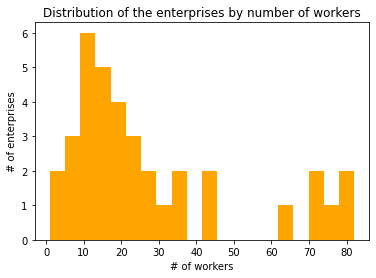

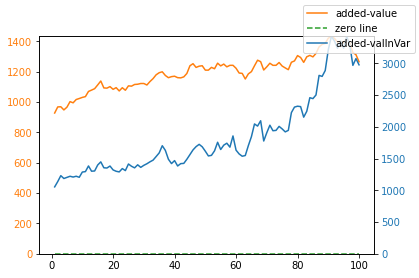

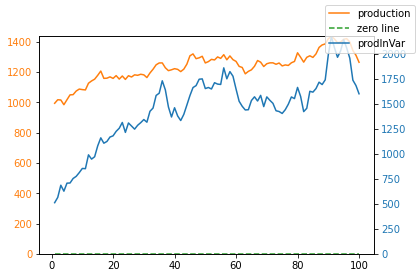

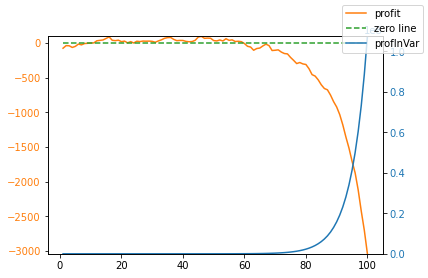

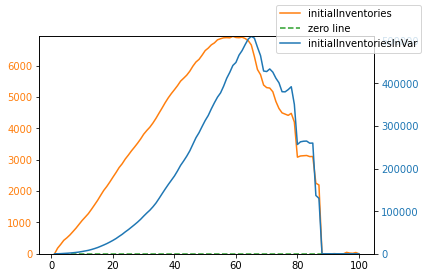

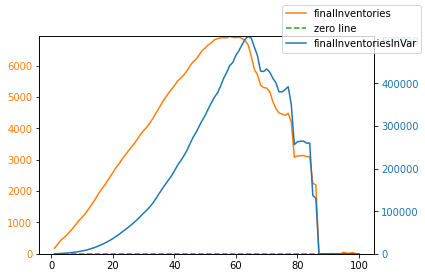

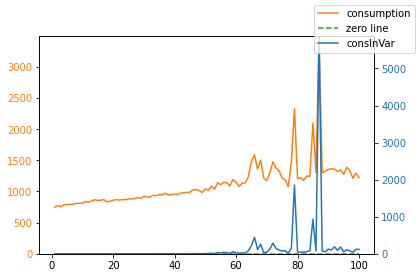

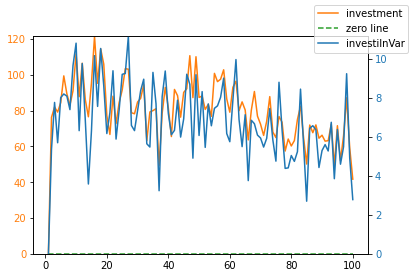

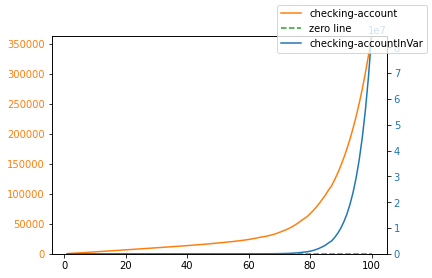

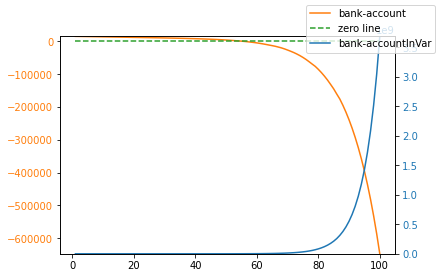

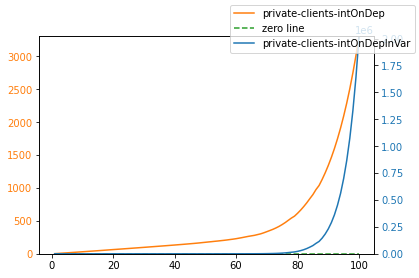

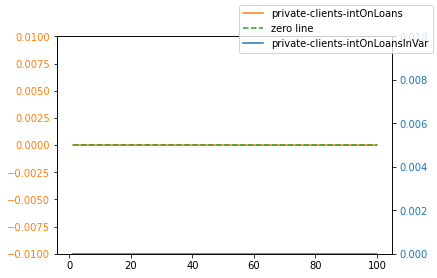

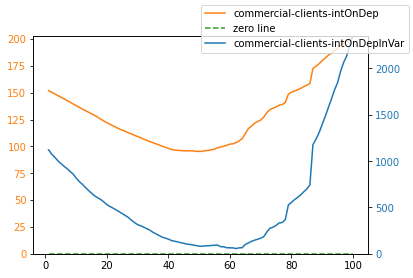

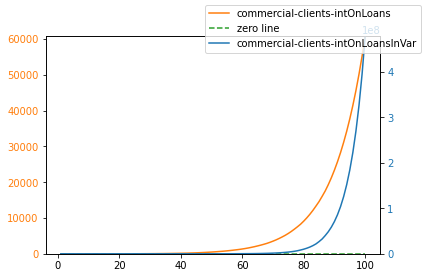

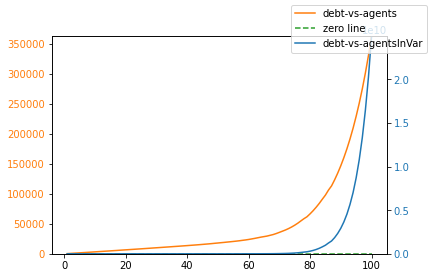

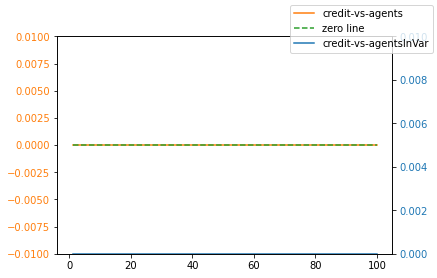

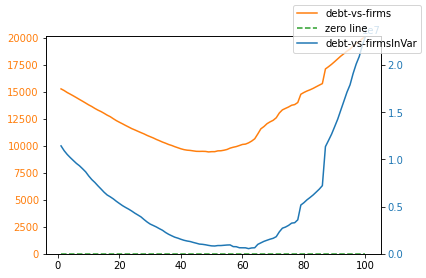

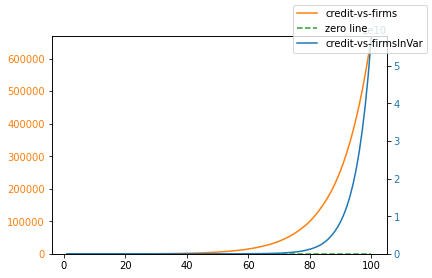

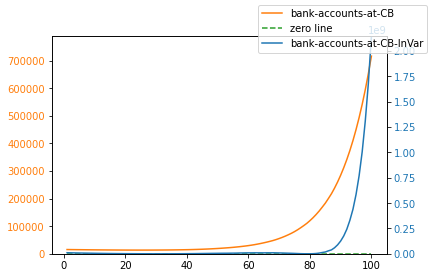

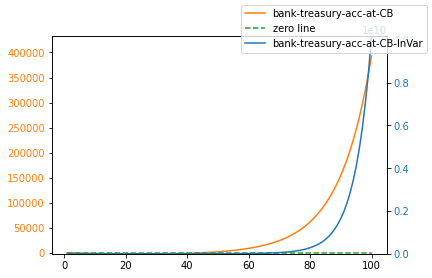

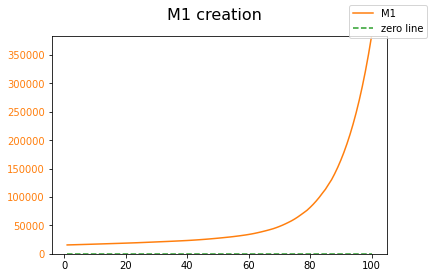

In [8]:
# the seed must be in range -2147483648 to 2147483647
r.seed(12345)

generateSeeds()

setup(r,cmv.functionSeedList[0])

cmv.actionList=["copyAccounts()","produceAll()","payWagesAll()",\
                "buyConsumptionOrInvestmentGoodsAll(r,cmv.functionSeedList[3])",\
                "computeAndApplyInterestsAll()","makeBalanceSheetAll()",\
                "distributeDividendAll()","accountCashMoneyAll()",\
                "accountCheckingAccountAll()","accountBankAccountAll()",\
                "makeBankFinancialAccountsAll()"\
                ]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

makeHist() 

nationalAccounts()

makePlots()


In [9]:
%run -i test

ModuleNotFoundError: No module named 'tabulate'

<Figure size 432x288 with 0 Axes>